<b>Author:</b> Jhosimar George Arias Figueroa

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load MNIST images 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
n_samples = mnist.train.num_examples
m_features = mnist.train.images.shape[1]
print("Number of Samples: {}. Feature Dimension: {}".format(n_samples, m_features))

Number of Samples: 55000. Feature Dimension: 784


### Data Visualization

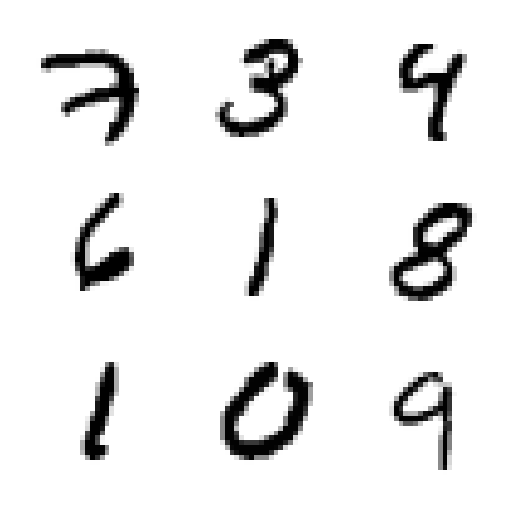

In [4]:
plt.figure(figsize=[6,6])
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(np.reshape(-mnist.train.images[i], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')

### Variational Autoencoder Class
Variational Autoencoder consist of an encoder, a decoder and a loss function.

#### Encoder
Encoder network receives as input the image representation, in case of MNIST dataset it is a 28x28 pixel image.
The encoder *‘encodes’* the data which is 784-dimensional into a latent (hidden) representation space z, which is much less than 784 dimensions. 

In our class, the encoder calculates the mean and standard deviation of the gaussian which will produce the latent variable z.

#### Decoder
Decoder network receives as input the latent variable z. The decoder *‘decodes’* the real-valued numbers in z into 784 real-valued numbers between 0 and 1. Information is lost because it goes from a smaller to a larger dimensionality.

#### Loss function
The loss function of the variational autoencoder is the negative log-likelihood with a regularizer.
\begin{align}
L^{\tt{v}} & = \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) - D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right)&\\
\end{align}

The first term is the reconstruction loss, or expected negative log-likelihood of the i-th datapoint. This term encourages the decoder to learn to reconstruct the data. If the decoder’s output does not reconstruct the data well, it will incur a large cost in this loss function.

The second term is a regularizer. This is the Kullback-Leibler divergence between the encoder’s distribution q(z∣x) and p(z). This divergence measures how much information is lost when using q to represent p. It is one measure of how close q is to p.

In [5]:
### Auxiliary Methods for Network Creation
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

In [6]:
class VariationalAutoencoder():
    
    # VAE initialization
    def __init__(self, **options ):
        self.latent_dim = options.get("latent_dim",20)           # latent space dimension (z)
        self.batch_size = options.get("batch_size", 200)         # training batch size
        self.epochs = options.get("epochs", 100)                 # number of training epochs
        self.learning_rate = options.get("learning_rate", 0.01)  # learning rate
        self.sess = tf.Session()                                 # tensorflow session
        self.display_step = options.get("display_step", 1)       # display loss
    
    # Encoder network
    # input: data (num_samples x num_features )
    # output: parameters for variance and standard deviation
    def encoder(self, X):
        with tf.variable_scope("encoder"):
            #first hidden_layer
            W1 = weight_variable([self.num_features, 500]) 
            b1 = bias_variable([500])
            h1 = tf.nn.tanh( tf.matmul(X,W1) + b1 )
            
            #hidden layer 2
            W2 = weight_variable([500, 250])
            b2 = bias_variable([250])
            h2 = tf.nn.tanh(tf.matmul(h1,W2) + b2)
            
            #mean layer
            W_mean = weight_variable([250, self.latent_dim])
            b_mean = bias_variable([self.latent_dim])
            h_mean = tf.matmul(h2, W_mean) + b_mean
            
            #variance layer
            W_logVar = weight_variable([250, self.latent_dim])
            b_logVar = bias_variable([self.latent_dim])
            h_logVar = tf.matmul(h2,W_logVar) + b_logVar
            
        return h_mean, h_logVar
    
    
    # Decoder network
    # input: representation z previously obtained from encoder
    # output: reconstruction of initial data X
    def decoder(self,z):
        with tf.variable_scope("decoder"):
           
            #hidden layer 1
            W_latent = weight_variable([self.latent_dim, 250])
            b_latent = bias_variable([250])
            h_latent = tf.nn.tanh(tf.matmul(z , W_latent) + b_latent )
            
            #hidden layer 2
            W2 = weight_variable([250, 500])
            b2 = bias_variable([500])
            h2 = tf.nn.tanh(tf.matmul(h_latent, W2) + b2)
            
            #reconstruction layer
            W1 = weight_variable([500, self.num_features])
            b1 = bias_variable([self.num_features])
            X = tf.nn.sigmoid(tf.matmul(h2, W1) + b1)
            
        return X   
    
    # Reparametrization trick 
    # N(z; μ, σI) = μ + σε
    def gaussian_latent_space(self, mean, logVar):
        noise = tf.random_normal(tf.shape(mean), mean = 0 , stddev = 1, dtype= tf.float32)
        z = mean + tf.sqrt(tf.exp(logVar)) * noise
        return z
    
    # cross_entropy(t,o) = -(t * log(o) + (1-t) * log(1-o)) 
    @staticmethod
    def binary_cross_entropy(x, x_reconstructed, offset = 1e-8):
        return -tf.reduce_sum( x * tf.log( offset + x_reconstructed ) + 
                              (1 - x) * tf.log( offset + 1 - x_reconstructed ) , 1)
    
    # divergence = -1/2 * sum( 1 + log(sigma^2) - sigma^2 - mean^2 )
    @staticmethod
    def KL_divergence(mean, logVar):
        return -0.5 * tf.reduce_sum(1 + logVar - 
                                    tf.exp(logVar) - tf.square(mean), 1 ) 
    
    # Train VAE
    def train(self, data):
        self.num_features = data.shape[1]
        self.num_samples = data.shape[0]
        
        self.X = tf.placeholder(tf.float32, [None, self.num_features])

        # Calculate mean and std from input data
        z_mean, z_logVar = self.encoder(self.X)
        
        # Create gaussian sampler z
        self.z_latent = self.gaussian_latent_space(z_mean, z_logVar)
        
        # Reconstruct data from latent sample z
        self.reconstructed = self.decoder(self.z_latent)

        # Loss = Reconstruction loss + KL-divergence cost
        divergence_loss = self.KL_divergence(z_mean, z_logVar)
        reconstruction_loss = self.binary_cross_entropy(self.X, self.reconstructed)
        total_loss = tf.reduce_mean(reconstruction_loss + divergence_loss)
        
        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(total_loss)
       
        # Variable initialization
        self.sess.run(tf.global_variables_initializer())
        num_batches = int(self.num_samples/self.batch_size)

        # Number of iterations
        for epoch in range(self.epochs):
            avg_loss = 0
            avg_divergence = 0
            avg_reconstruction = 0
            
            # Iterate on each batch
            for i in range(num_batches):
                # Get current batch
                batch_X = data[i * self.batch_size: i * self.batch_size + self.batch_size ][:]
                
                # Train VAE and get current losses
                _, kl_loss, rec_loss, tot_loss = self.sess.run( (optimizer, divergence_loss, 
                                                                 reconstruction_loss, total_loss), 
                                                                 feed_dict={self.X : batch_X} )
                avg_divergence += np.mean( kl_loss )
                avg_reconstruction += np.mean( rec_loss )
                avg_loss += tot_loss
            
            avg_reconstruction /= num_batches
            avg_divergence /= num_batches
            avg_loss /= num_batches
            if( epoch % self.display_step == 0 ):
                print("Epoch {}: -- Divergence={}, Reconstruction={}, Loss={}".format(epoch + 1, avg_divergence, 
                                                                                avg_reconstruction, avg_loss))

            
    # Visualize original and generated sample
    # input: sample with dimensions (1 x num_features)
    def visualize_generation(self, x_sample):
        x_reconstruct = self.sess.run(self.generated, feed_dict={self.x: x_sample})
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(x_sample.reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(x_reconstruct[0].reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
        plt.axis('off')
        
    # Generate batch of samples
    # input: noise (n x latent_dim)
    # output: generated images (n x num_features)
    def generate_data(self, num_samples, noise = None):
        if( noise == None):
            noise = np.random.normal(0, 1 , [num_samples, self.latent_dim])
        generated = self.sess.run(self.reconstructed, feed_dict={self.z_latent: noise})
        return generated
    
    # Reconstruct batch of samples
    # input: batch data (n x num_features), label (int or one-hot:n x num_categories)
    # output: reconstructed images (n x num_features)
    def reconstruct_data(self, data):
        x_reconstruct = self.sess.run(self.reconstructed, feed_dict={self.X: data})
        return x_reconstruct

#### TrainingVariational Autoencoder

In [7]:
# Load train data
train_data = mnist.train.images

# VAE Instantiation
VAE = VariationalAutoencoder(latent_dim = 20, batch_size = 100, epochs = 100, learning_rate = 0.001, display_step = 10)

# Training Vanilla VAE
VAE.train(train_data)

Epoch 1: -- Divergence=19.6713559324, Reconstruction=136.584507183, Loss=156.25586276
Epoch 11: -- Divergence=24.3256355875, Reconstruction=82.8152629922, Loss=107.140897772
Epoch 21: -- Divergence=24.4086328402, Reconstruction=79.8465673551, Loss=104.255200195
Epoch 31: -- Divergence=24.3243812908, Reconstruction=78.450074879, Loss=102.774456177
Epoch 41: -- Divergence=24.2474290536, Reconstruction=77.6640917414, Loss=101.911520954
Epoch 51: -- Divergence=24.1420958675, Reconstruction=77.056489993, Loss=101.198586232
Epoch 61: -- Divergence=24.0286658755, Reconstruction=76.9766065563, Loss=101.005272411
Epoch 71: -- Divergence=24.0117982344, Reconstruction=76.5038442993, Loss=100.515642326
Epoch 81: -- Divergence=23.9269706761, Reconstruction=76.1186827504, Loss=100.045653465
Epoch 91: -- Divergence=23.9121080572, Reconstruction=76.1259671437, Loss=100.03807509


In [8]:
# Load test data
test_batch = mnist.test.next_batch(10)
test_batch_data = test_batch[0]

### Data Reconstruction

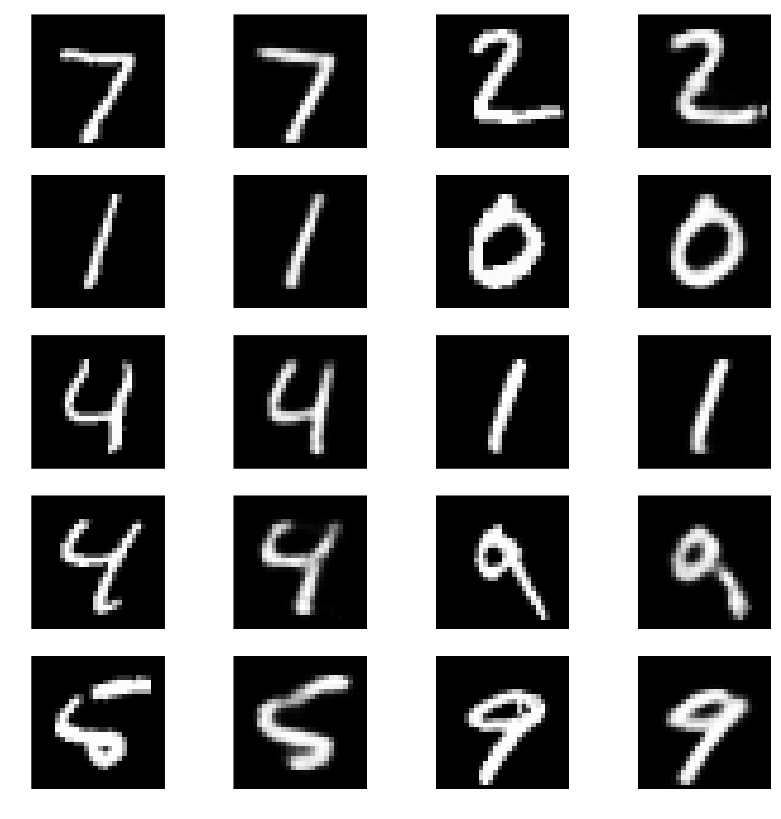

In [9]:
reconstructed = VAE.reconstruct_data(test_batch_data)

plt.figure(figsize=[10,10])
index = 0
for i in range(0,20, 4):
    plt.subplot(5,4,i+1)
    plt.imshow(np.reshape(test_batch_data[index], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplot(5,4,i+2)
    plt.imshow(np.reshape(reconstructed[index], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplot(5,4,i+3)
    plt.imshow(np.reshape(test_batch_data[index+1], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplot(5,4,i+4)
    plt.imshow(np.reshape(reconstructed[index+1], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')
    index = index + 2

### Data Generation

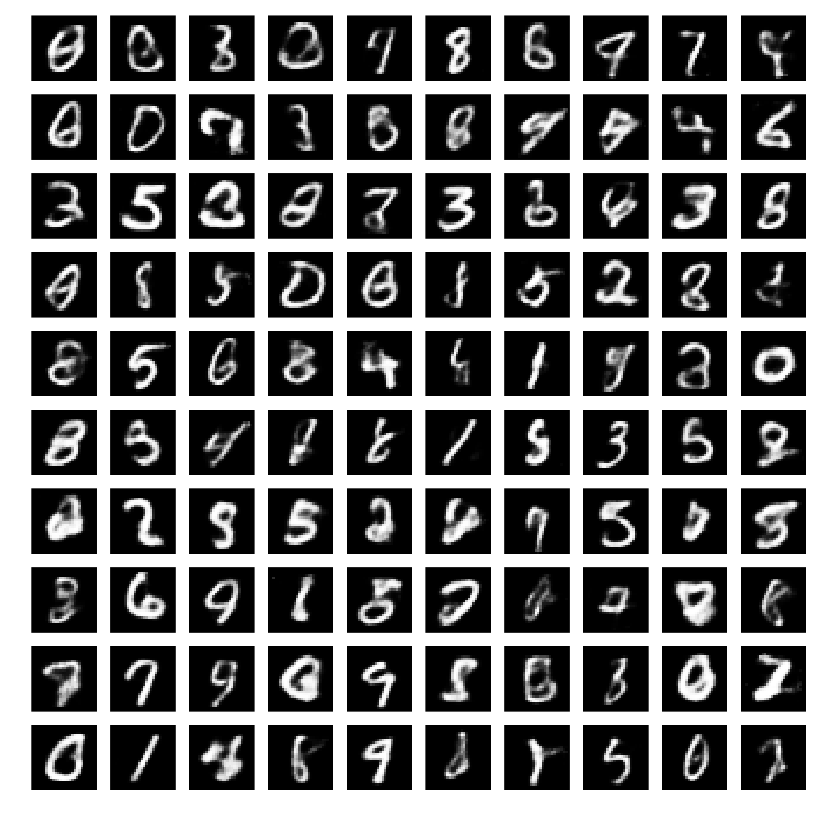

In [10]:
# Generate images
generated = VAE.generate_data(100)
plt.figure(figsize=[10,10])
for i in range(0,100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(generated[i], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')